In [21]:
"""
Machine Learning Homework 1
Done by:
Mariana Santana 106992
Pedro Leal 106154
LEIC-A
"""

'\nMachine Learning Homework 1\nDone by:\nMariana Santana 106992\nPedro Leal 106154\nLEIC-A\n'

#### II. Programming
#### Consider the diabetes.arff data available at the homework tab, comprising 8 biological features to classify 768 patients into 2 classes (normal, diabetes).

In [22]:

"""
General imports and variables for all exercises; run this cell before any other
"""

import arff, pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt
from sklearn import tree, metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_classif, mutual_info_classif

dataset = arff.load(open("diabetes.arff", "r"))
attribute_names = [attr[0] for attr in dataset['attributes']]
data_dict = {attr: [] for attr in attribute_names}

for row in dataset['data']:
    for i, value in enumerate(row):
        data_dict[attribute_names[i]].append(value)

df = pd.DataFrame(data_dict)

X, y = df.drop('Outcome', axis=1), df['Outcome']

#### 1. ANOVA is a statistical test that can be used to assess the discriminative power of a single input variable. Using f_classif from sklearn, identify the input variables with the worst and best discriminative power. Plot their class-conditional probability density functions.

Text(0, 0.5, 'Probability Density')

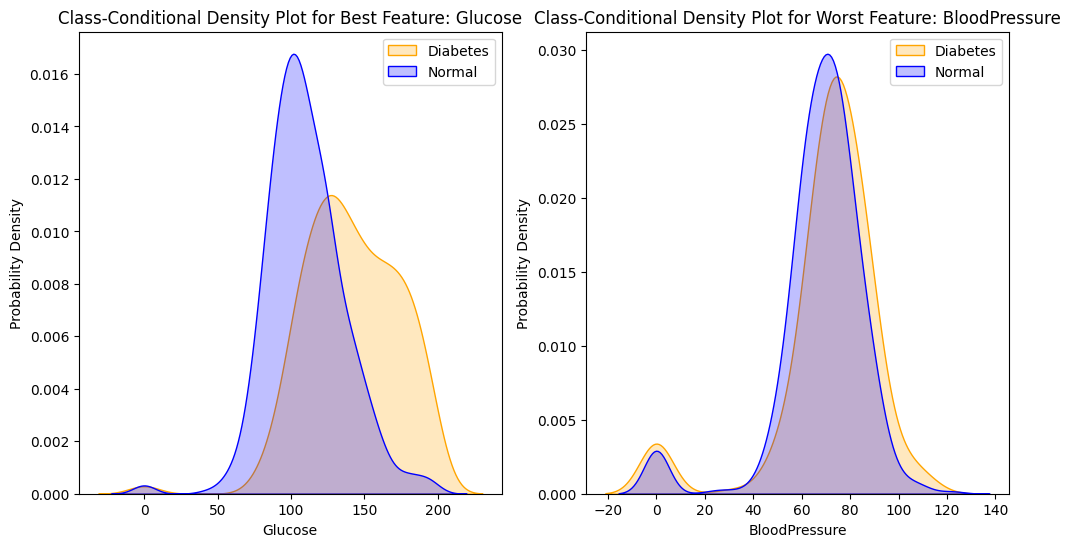

In [23]:
f_values, p_values = f_classif(X, y)

feature_scores = pd.DataFrame({
    'Feature': X.columns,
    'F-Value': f_values,
    'p-Value': p_values
})

feature_scores = feature_scores.sort_values(by='F-Value', ascending=False)
best_feature = feature_scores.iloc[0]['Feature']
worst_feature = feature_scores.iloc[-1]['Feature']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.kdeplot(df[best_feature][df['Outcome'] == '1'], label='Diabetes', color='orange', fill=True)
sns.kdeplot(df[best_feature][df['Outcome'] == '0'], label='Normal', color='b', fill=True)
plt.title(f'Class-Conditional Density Plot for Best Feature: {best_feature}')
plt.legend()
plt.xlabel(best_feature)
plt.ylabel('Probability Density')
plt.subplot(1, 2, 2)
sns.kdeplot(df[worst_feature][df['Outcome'] == '1'], label='Diabetes', color='orange', fill=True)
sns.kdeplot(df[worst_feature][df['Outcome'] == '0'], label='Normal', color='b', fill=True)
plt.title(f'Class-Conditional Density Plot for Worst Feature: {worst_feature}')
plt.legend()
plt.xlabel(worst_feature)
plt.ylabel('Probability Density')


#### 2. Using a stratified 80-20 training-testing split with a fixed seed (random_state=1), assess in a single plot both the training and testing accuracies of a decision tree with minimum sample split in {2,5,10,20,30,50,100} and the remaining parameters as default. Note that split thresholding of numeric variables in decision trees is non-deterministic in sklearn, hence you may opt to average the results using 10 runs per parameterization.

Train accuracies:  [0.9934853420195437, 0.9657980456026058, 0.9397394136807817, 0.8843648208469055, 0.8485342019543974, 0.8403908794788274, 0.7850162866449512] 
Test accuracies:  [0.7207792207792207, 0.7142857142857143, 0.7142857142857143, 0.7597402597402596, 0.7662337662337662, 0.7597402597402596, 0.7467532467532468]


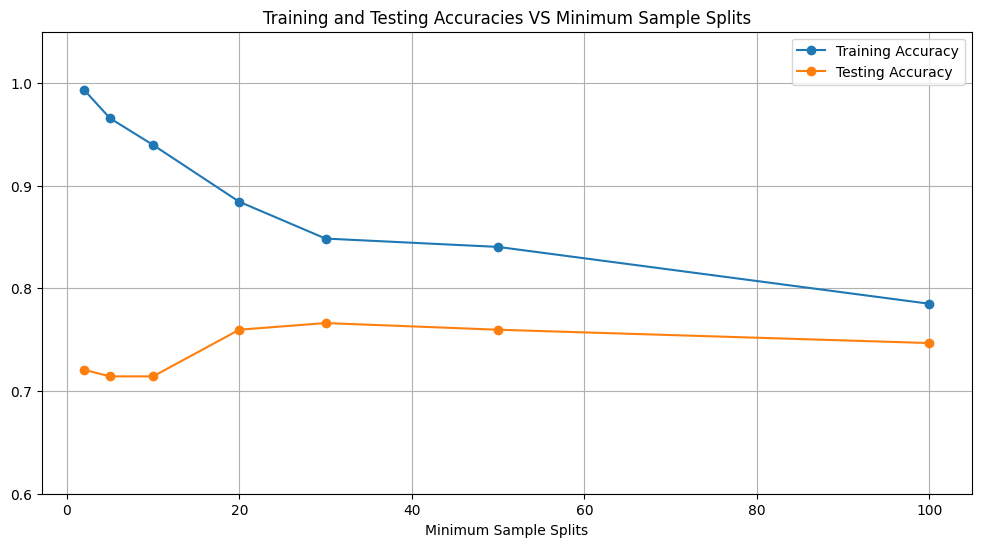

In [24]:
min_samples_split_values = [2, 5, 10, 20, 30, 50, 100]
n_runs, random_state = 10, 1
train_accuracies, test_accuracies = [], []

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, random_state=random_state)

feature_scores = mutual_info_classif(X_train, y_train)
sorted_features = np.argsort(feature_scores)

for m in min_samples_split_values:

    train_m_acc, test_m_acc = [], []
    predictor = tree.DecisionTreeClassifier(min_samples_split=m, random_state=random_state)

    for _ in range(n_runs):
        top_features = sorted_features[-m:]
        X_m_train, X_m_test = X_train.iloc[:, top_features], X_test.iloc[:, top_features]

        predictor.fit(X_m_train, y_train)
        train_m_acc.append(metrics.accuracy_score(y_train, predictor.predict(X_m_train)))
        test_m_acc.append(metrics.accuracy_score(y_test, predictor.predict(X_m_test)))
    
    train_accuracies.append(np.mean(train_m_acc))
    test_accuracies.append(np.mean(test_m_acc))

print("Train accuracies: ", train_accuracies, "\nTest accuracies: ", test_accuracies)

plt.figure(figsize=(12, 6))
plt.plot(min_samples_split_values, train_accuracies, label='Training Accuracy', marker='o')
plt.plot(min_samples_split_values, test_accuracies, label='Testing Accuracy', marker='o')
plt.title('Training and Testing Accuracies VS Minimum Sample Splits')
plt.xlabel('Minimum Sample Splits')
plt.ylim(0.6, 1.05)
plt.legend()
plt.grid()


#### 3. Critically analyze these results, including the generalization capacity across settings.
With the analysis of the resulting plot from exercise 2, it's possible to assess the relation between the number of min_sample_splits and the testing and training accuracies and, therefore, the model's generalization capacity.

For min_sample_splits between 0 and 25, the training accuracy is quite high as opposed to the testing accuracy, as seen in the plot. This happens because smaller min_sample_split values allow the decision tree to get deeper and more complex, causing the model to memorize the data rather than generalize patterns, leading to overfitting.

On the other hand, for min_sample_split between 40 and 100, as the values increase, testing accuracy decreases slightly, and training accuracy drops more significantly. This happens because increasing the min_sample_split results in a simpler and shallower decision tree, making the model too simplistic to effectively capture patterns in the training data, leaning towards underfitting.

In conclusion, lowering the min_sample_split value increases the likelihood of overfitting, while raising it increases the risk of underfitting. In this case, the optimal min_sample_split value is around 30, as that is where testing accuracy reaches its peak, indicating improved generalization capacity.

#### 4. To deploy the predictor, a healthcare provider opted to learn a single decision tree (random_state=1) using all available data and ensuring that the maximum depth would be 3 in order to avoid overfitting risks. 
#### i. Plot the decision tree.

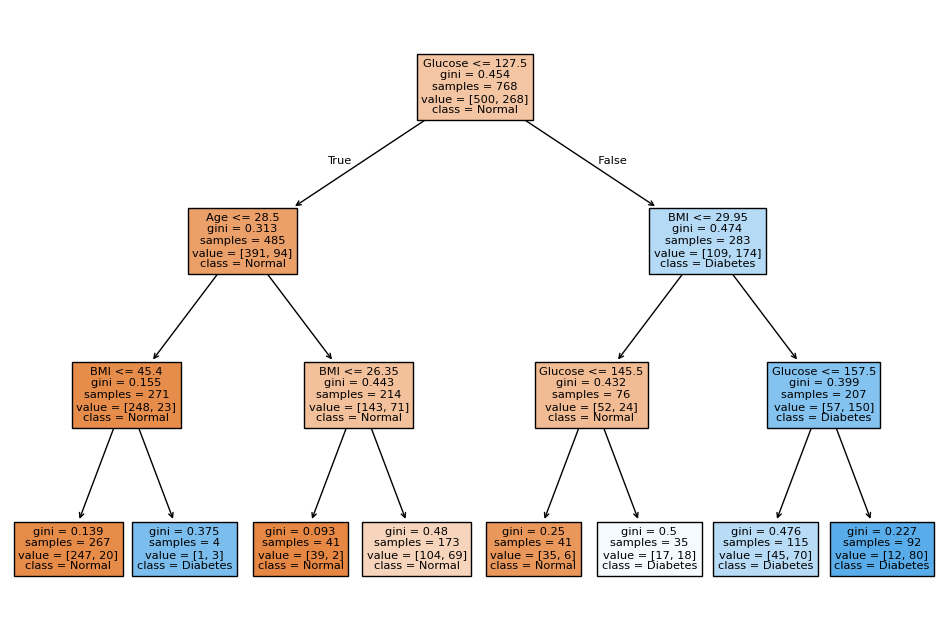

In [25]:
clf = tree.DecisionTreeClassifier(max_depth=3, random_state=1)
clf.fit(X, y)

plt.figure(figsize=(12, 8))
tree.plot_tree(clf, feature_names=X.columns, class_names=['Normal', 'Diabetes'], filled=True)
plt.show()


### ii. Explain what characterizes diabetes by identifying the conditional associations together with their posterior probabilities.

Upon analysing the decision tree, the main features that characterize diabetes are, in order of importance: Glucose, BMI and Age. In the following table, we present the interpretation of the decision tree for the class “Diabetes” and the conditions for each features along with the probability of the class in the tree’s nodes.

|P(class = Diabetes)|Conditions|
|--------|---------|
|3/4|Glucose <= 127.5, Age <= 28.5 and BMI > 45.4|
|18/35|Glucose > 145.5 and BMI <= 29.95|
|70/115|127.5 < Glucose <= 157.5 and BMI <= 29.95|
|80/92|127.5 < Glucose <= 157.5 and BMI > 29.95|